# Processing API request

In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import time
import datetime
import numpy as np

import matplotlib.pyplot as plt 

from eolearn.io import SentinelHubProcessingInput, SentinelHubWCSInput
from eolearn.core import FeatureType, OverwritePermission
from sentinelhub import CRS, BBox, DataSource

In [21]:
bbox = BBox(bbox=[268892, 4624365, 268892+1000, 4624365+1000], crs=CRS.UTM_33N) 
time_interval = ('2017-12-15', '2018-3-30')
maxcc = 0.8
time_difference = 60

In [22]:
task = SentinelHubProcessingInput('test_feature', size_x=100, size_y=100, time_range=time_interval, bbox=bbox, maxcc=maxcc, time_difference=time_difference, store='32bit')
eopatch_proc = task.execute()
proc_images = eopatch_proc[(FeatureType.DATA, 'test_feature')]

# Request the same image with the SentinelHubWCSInput for comparison

In [23]:
input_task = SentinelHubWCSInput(
    layer='BANDS-S2-L1C',
    resx='10m',
    resy='10m',
    maxcc=maxcc,
    data_source=DataSource.SENTINEL2_L1C
)

In [24]:
eopatch_wcs = input_task.execute(
    bbox=bbox,
    time_interval=time_interval
)

In [25]:
wcs_images = eopatch_wcs.data['BANDS-S2-L1C']

# Result comparison

In [26]:
print('WCS shape..........:', wcs_images.shape)
print('PROCESSING shape...:', proc_images.shape)

WCS shape..........: (21, 100, 100, 13)
PROCESSING shape...: (21, 100, 100, 13)


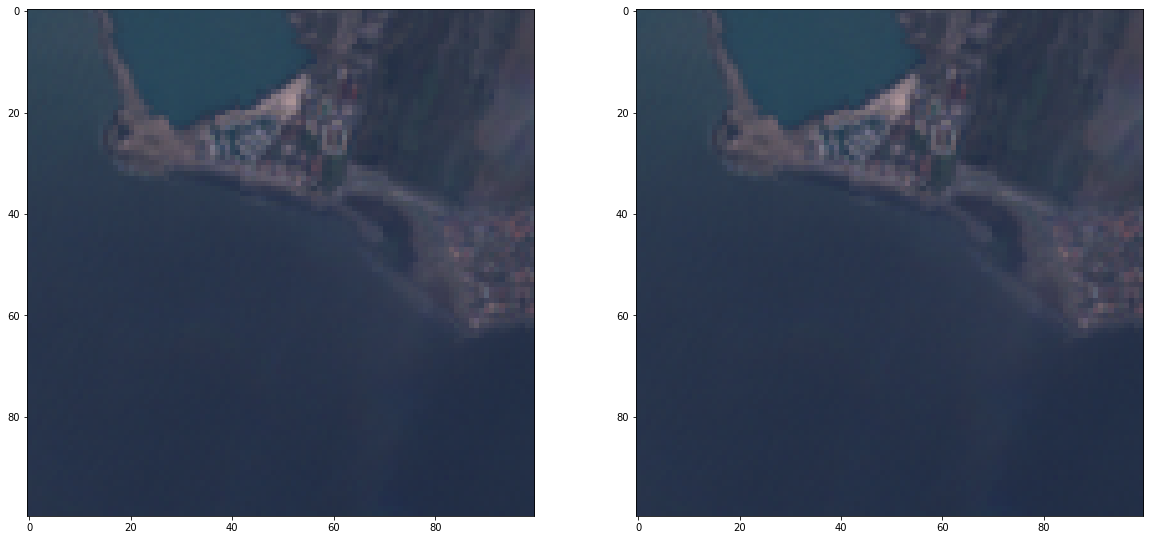

In [34]:
image_index = 0
plt.figure(figsize=(20,20))
plt.subplot2grid((1, 2), (0, 0)).imshow(proc_images[image_index][..., [3,2,1]] * 2.5, vmin=0, vmax=1);
plt.subplot2grid((1, 2), (0, 1)).imshow(wcs_images[image_index][..., [3,2,1]] * 2.5, vmin=0, vmax=1);

In [28]:
np.array_equal(proc_images, wcs_images)

True

In [29]:
proc_images[0,3,5,2], wcs_images[0,3,5,2]

(0.119, 0.119)

# 16bit vs 32 bit storage

In [30]:
common_kwargs = dict(size_x=100, size_y=100, time_range=time_interval, bbox=bbox, maxcc=maxcc, time_difference=time_difference)

eopatch16 = SentinelHubProcessingInput('data_16', store='16bit', **common_kwargs)()
eopatch32 = SentinelHubProcessingInput('data_32', store='32bit', **common_kwargs)()

In [31]:
eopatch16.save('patch16', overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
eopatch32.save('patch32', overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [42]:
import os
import math

def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)

    return convert_size(total_size)

In [43]:
print('cache:', get_size('cache_dir'))
print('16bit:', get_size('patch16'))
print('32bit:', get_size('patch32'))

cache: 1.61 MB
16bit: 5.21 MB
32bit: 10.41 MB
